# Machine Learning Approach for Relation Extraction

This notebook is divided into four sections:
- Data Preprocessing: Processes the annotated data and extracts the specified features.
- Model Training: Trains three machine learning models using the extracted features.
- Model Testing: Uses the trained models to predict relationships between entities in the preprocessed dataset.

## Installing Dependecies

In [1]:
!pip install xgboost
!pip install spacy
!pip install joblib
!pip install pandas numpy scikit-learn matplotlib seaborn
!python -m spacy download en_core_web_md

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.8.0/en_core_web_md-3.8.0-py3-none-any.whl (33.5 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
import json
import pandas as pd
import spacy
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

In [5]:
# Load spaCy model
nlp = spacy.load("en_core_web_md")

## Data Preprocessing

In [ ]:
def feature_extraction(data, isTrain): 
    # Extract the required features to train the ML model
    structured_data = []
    
    for entry in data:
        text = entry["text"]
        entities = {e["entity_id"]: e for e in entry["entities"]}
        relations = entry["relations"]
    
        for relation in relations:
            entity1 = entities[relation["arg1"]]
            entity2 = entities[relation["arg2"]]
    
            # Extract entity types
            entity1_type = entity1["label"]
            entity2_type = entity2["label"]
    
            # Get text between entities
            entity1_end = entity1["end"]
            entity2_start = entity2["start"]
            if entity1_end < entity2_start:
                between_text = text[entity1_end:entity2_start].strip()
            else:
                between_text = text[entity2["end"]:entity1["start"]].strip()
    
            # Process sentence with spaCy
            doc = nlp(text)
            tokens = [token.text for token in doc]
    
            # Find root words of entities (headword embedding)
            entity1_root, entity2_root = None, None
            for token in doc:
                if token.text in entity1["text"].split():
                    entity1_root = token
                if token.text in entity2["text"].split():
                    entity2_root = token
    
            entity1_head_emb = entity1_root.vector if entity1_root else np.zeros(300)
            entity2_head_emb = entity2_root.vector if entity2_root else np.zeros(300)
    
            # Calculate span similarity
            if np.linalg.norm(entity1_head_emb) == 0 or np.linalg.norm(entity2_head_emb) == 0:
                span_similarity = 0
            else:
                span_similarity = 1 - cosine(entity1_head_emb, entity2_head_emb)
    
            # Extract dependency path
            dependency_path = "None"
            if entity1_root and entity2_root:
                dependency_path = entity1_root.dep_ + " → " + entity2_root.dep_
    
            # Extract POS tags
            entity1_POS = entity1_root.pos_ if entity1_root else "UNKNOWN"
            entity2_POS = entity2_root.pos_ if entity2_root else "UNKNOWN"
    
            # Extract sentence length & word distance
            sentence_length = len(text.split())
            word_distance = len(between_text.split())
    
            # Create dictionary with extracted features
            entry_data = {
                "sentence": text,
                "entity1": entity1["text"],
                "entity1_type": entity1_type,
                "entity2": entity2["text"],
                "entity2_type": entity2_type,
                "text_between_entities": between_text,
                "sentence_length": sentence_length,
                "word_distance": word_distance,
                "dependency_path": dependency_path,
                "entity1_POS": entity1_POS,
                "entity2_POS": entity2_POS,
                "span_similarity": span_similarity
            }
            
            # Add relation if training
            if isTrain:
                entry_data["relation"] = relation["type"]
            
            # Append the complete dictionary to structured_data
            structured_data.append(entry_data)
                
    # Convert structured data to DataFrame
    df = pd.DataFrame(structured_data)
    return df

In [ ]:
def lemmatize_text(text):
    # Convert words to their base form (lemma).
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def tf_idf(text, isTrain = False):
    # Apply lemmatization before TF-IDF
    text = text.apply(lemmatize_text)

    global vectorizer
    # Compute TF-IDF on lemmatized text
    if isTrain:
        vectorizer = TfidfVectorizer(max_features=100)
        X_tfidf = vectorizer.fit_transform(text)
         # Save the trained vectorizer
        joblib.dump(vectorizer, "tf_idf_vectorizer.pkl")
    else:
        vectorizer = joblib.load("tf_idf_vectorizer.pkl")
        X_tfidf = vectorizer.transform(text)
    
    # Convert TF-IDF matrix to DataFrame
    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=[f"tfidf_{i}" for i in range(100)])
    return tfidf_df

In [ ]:
def label_encode(df, columns_to_encode, isTrain = False):
    label_encoders = {}
    for column in columns_to_encode:
        if isTrain:
            label_encoders[column] = LabelEncoder()
            df[column + "_encoded"] = label_encoders[column].fit_transform(df[column])
        else:
            label_encoders = joblib.load("label_encoders.pkl")
            # Handle unseen categories by assigning them to -1
            df[column + "_encoded"] = df[column].apply(lambda x: label_encoders[column].transform([x])[0] if x in label_encoders[column].classes_ else -1)
    # Save the encoder
    if isTrain:
        joblib.dump(label_encoders, "label_encoders.pkl")
    return df

In [14]:
def normalise(df, columns_to_normalise, isTrain = False):
    # Scale some of the features
    if isTrain:
        scaler = StandardScaler()
        df[columns_to_normalise] = scaler.fit_transform(df[columns_to_normalise])
        joblib.dump(scaler,"Standard_Scaler.pkl")
    else:
        scaler = joblib.load("Standard_Scaler.pkl")
        df[columns_to_normalise] = scaler.transform(df[columns_to_normalise])
    return df

In [16]:
def prepare_data(df, features):
    
    # Prepare X (features) and y (labels)
    X = df[features]
    y = df["relation_encoded"]

    return X,y

In [18]:
def main_preprocess(isTrain, test_data, train_data = None):

    # Columns to label encode and normalise
    columns_to_encode = ["entity1_type", "entity2_type", "dependency_path", "entity1_POS", "entity2_POS"]
    columns_to_normalise = ["sentence_length", "word_distance", "dependency_path_encoded"]
    # Select the features
    features = [
        "entity1", "entity2", "entity1_type_encoded", "entity2_type_encoded",
        "sentence_length", "word_distance",
        "dependency_path_encoded", "entity1_POS_encoded", "entity2_POS_encoded",
        "span_similarity"
    ]
    # Add TF-IDF features
    features.extend(f"tfidf_{i}" for i in range(100))
    
    if isTrain:
        columns_to_encode.append("relation")
        # Extract the features for the ML model
        train_df = feature_extraction(train_data, isTrain)
        # Get TF-IDF features for the text between the entities
        tfidf_df = tf_idf(train_df["text_between_entities"], True)    
        # Merge TF-IDF features into main dataset
        train_df = pd.concat([train_df, tfidf_df], axis=1)

        # Label encode the categorical columns
        train_df = label_encode(train_df, columns_to_encode, True)

        # Normalize features
        train_df = normalise(train_df, columns_to_normalise, True)

        # Get features and labels and save the datasets
        X_train, y_train = prepare_data(train_df, features)
        X_train.to_csv("ML_features_train.csv", index=False)
        y_train.to_csv("ML_labels_train.csv", index=False)
        
        
    # Extract the features for the ML model
    test_df = feature_extraction(test_data, isTrain)
    
    # Get TF-IDF features for test set
    tfidf_df = tf_idf(test_df["text_between_entities"])
    # Merge TF-IDF features into main dataset
    test_df = pd.concat([test_df, tfidf_df], axis=1)

    # Label encode the categorical columns
    test_df = label_encode(test_df, columns_to_encode)

    # Normalize features
    test_df = normalise(test_df, columns_to_normalise)
    
    if isTrain:
        # Get features and labels and save the datasets
        X_test, y_test = prepare_data(test_df, features)
        X_test.to_csv("ML_features_test.csv", index=False)
        y_test.to_csv("ML_labels_test.csv", index=False)
    else:
        # Get features and save the dataset
        X = test_df[features]
        X.to_csv("ML_features_test.csv", index=False)

## Load the dataset

In [21]:
# Ask the user whether to train or only test
user_input = input("Enter 'train' to train new models or 'test' to evaluate the pretrained models on new data: ").strip().lower()
isTrain = user_input == "train"

# Load dataset
with open("dataset.json", "r") as f:
    data = json.load(f)

if isTrain:
    split_index = int(0.8 * len(data))
    train_data = data[:split_index]
    test_data = data[split_index:]
    main_preprocess(True, test_data, train_data)
    print("Train and test datasets processed and saved successfully")
else:
    main_preprocess(False, data)
    print("Test dataset processed and saved successfully")

Enter 'train' to train new models or 'test' to evaluate the pretrained models on new data:  train


Train and test datasets processed and saved successfully


## Model Training

SVM Accuracy: 0.6577453365774534 | F1 Score: 0.6272670240914706
Random Forest Accuracy: 0.716139497161395 | F1 Score: 0.6900774079583363
XGBoost Accuracy: 0.7210056772100568 | F1 Score: 0.7033319236392334

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.23      0.31        31
           1       0.74      0.63      0.68       128
           2       0.74      0.82      0.77       311
           3       0.49      0.26      0.34        70
           4       0.45      0.36      0.40        50
           5       0.55      0.27      0.36       124
           6       0.67      0.05      0.09        44
           7       0.64      0.84      0.72       475

    accuracy                           0.66      1233
   macro avg       0.60      0.43      0.46      1233
weighted avg       0.65      0.66      0.63      1233


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.

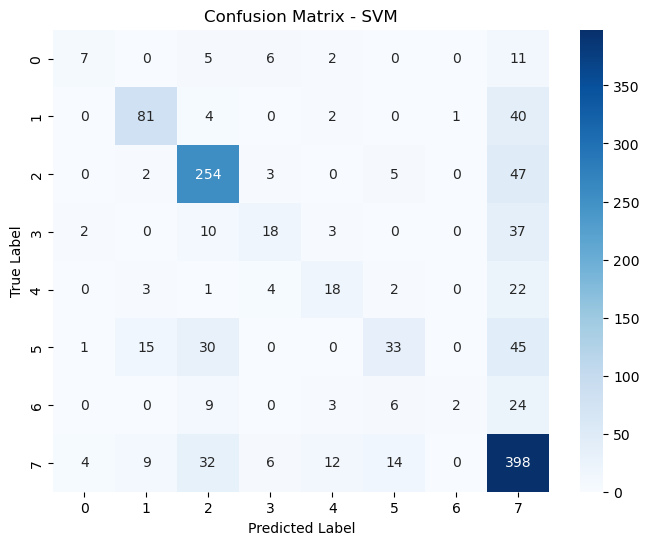

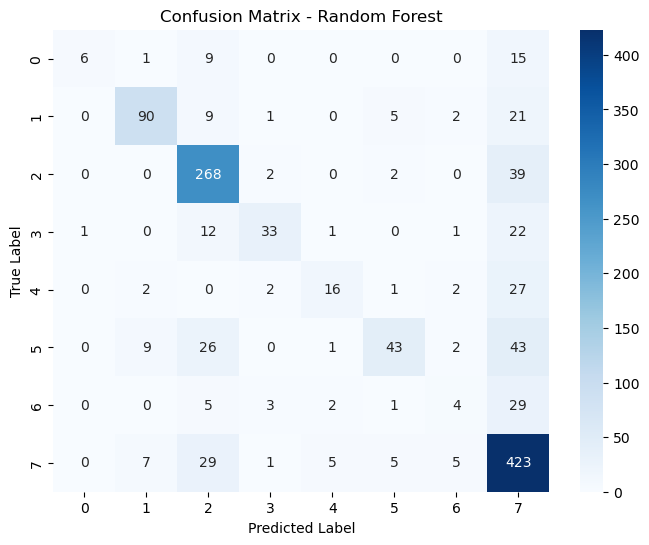

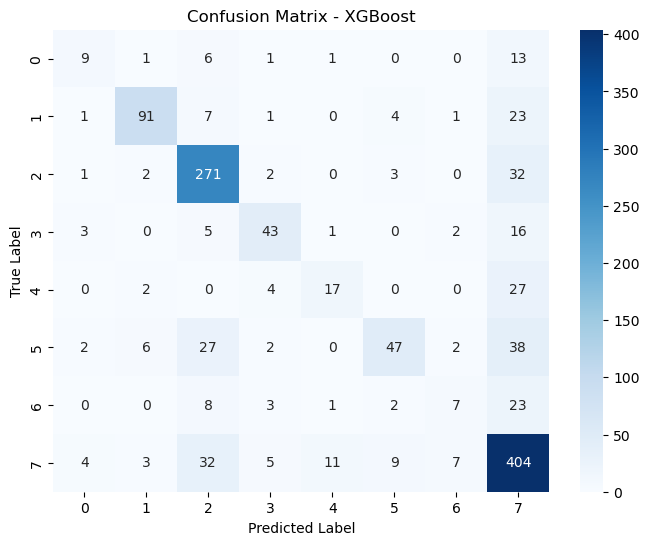

In [23]:
# Load the datasets
X_train = pd.read_csv("ML_features_train.csv")
y_train = pd.read_csv("ML_labels_train.csv")
X_test = pd.read_csv("ML_features_test.csv")
y_test = pd.read_csv("ML_labels_test.csv")

# Drop entity columns
X_train = X_train.drop(["entity1", "entity2"], axis=1)
X_test = X_test.drop(["entity1", "entity2"], axis=1)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Train SVM Model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost Model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predictions
svm_pred = svm_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Evaluate Models
svm_accuracy = accuracy_score(y_test, svm_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

# print("SVM Accuracy:", svm_accuracy)
# print("Random Forest Accuracy:", rf_accuracy)
# print("XGBoost Accuracy:", xgb_accuracy)

svm_f1 = f1_score(y_test, svm_pred, average="weighted")
rf_f1 = f1_score(y_test, rf_pred, average="weighted")
xgb_f1 = f1_score(y_test, xgb_pred, average="weighted")

# Print Results
print("SVM Accuracy:", svm_accuracy, "| F1 Score:", svm_f1)
print("Random Forest Accuracy:", rf_accuracy, "| F1 Score:", rf_f1)
print("XGBoost Accuracy:", xgb_accuracy, "| F1 Score:", xgb_f1)

print("\nSVM Classification Report:\n", classification_report(y_test, svm_pred))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_pred))
print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_pred))

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_true), yticklabels=set(y_true))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Plot Confusion Matrix for SVM
plot_confusion_matrix(y_test, svm_pred, "Confusion Matrix - SVM")

# Plot Confusion Matrix for Random Forest
plot_confusion_matrix(y_test, rf_pred, "Confusion Matrix - Random Forest")

# Plot Confusion Matrix for XGBoost
plot_confusion_matrix(y_test, xgb_pred, "Confusion Matrix - XGBoost")


In [24]:
# Load the label encoder
label_encoders = joblib.load("label_encoders.pkl")

# Inverse transform the numerical labels back to category names
true_labels = label_encoders["relation"].inverse_transform(y_test)
svm_labels = label_encoders["relation"].inverse_transform(svm_pred)
rf_labels = label_encoders["relation"].inverse_transform(rf_pred)
xgb_labels = label_encoders["relation"].inverse_transform(xgb_pred)

# Save Predicted Labels to CSV with actual category names
predictions_df = pd.DataFrame({
    "True Label": true_labels,
    "SVM Prediction": svm_labels,
    "Random Forest Prediction": rf_labels,
    "XGBoost Prediction": xgb_labels
})
predictions_df.to_csv("model_predictions_relations.csv", index=False)

# Print first few rows of predicted labels
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
  True Label SVM Prediction Random Forest Prediction XGBoost Prediction
0   USED-FOR       USED-FOR                 USED-FOR           USED-FOR
1   USED-FOR       USED-FOR                 USED-FOR           USED-FOR
2      COREF          COREF                    COREF              COREF
3      COREF          COREF                    COREF              COREF
4      COREF          COREF                    COREF              COREF


In [27]:
# Function to compute TP, FP, TN, FN for each relation
def compute_confusion_metrics(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    
    metrics = {}
    for i, label in enumerate(class_labels):
        TP = cm[i, i]  # True Positives
        FP = cm[:, i].sum() - TP  # False Positives
        FN = cm[i, :].sum() - TP  # False Negatives
        TN = cm.sum() - (TP + FP + FN)  # True Negatives

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[label] = {
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score
        }
    
    return metrics

# Get all unique relation labels
unique_labels = np.unique(true_labels)

# Compute metrics for each model
svm_metrics = compute_confusion_metrics(true_labels, svm_labels, unique_labels)
rf_metrics = compute_confusion_metrics(true_labels, rf_labels, unique_labels)
xgb_metrics = compute_confusion_metrics(true_labels, xgb_labels, unique_labels)

# Convert to DataFrame for better visualization
svm_metrics_df = pd.DataFrame.from_dict(svm_metrics, orient="index")
rf_metrics_df = pd.DataFrame.from_dict(rf_metrics, orient="index")
xgb_metrics_df = pd.DataFrame.from_dict(xgb_metrics, orient="index")

# Print results
print("\nSVM Metrics:")
print(svm_metrics_df)
print("\nRandom Forest Metrics:")
print(rf_metrics_df)
print("\nXGBoost Metrics:")
print(xgb_metrics_df)



SVM Metrics:
               TP   FP    TN  FN  Precision    Recall  F1-Score
COMPARE         7    7  1195  24   0.500000  0.225806  0.311111
CONJUNCTION    81   29  1076  47   0.736364  0.632812  0.680672
COREF         254   91   831  57   0.736232  0.816720  0.774390
EVALUATE-FOR   18   19  1144  52   0.486486  0.257143  0.336449
FEATURE-OF     18   22  1161  32   0.450000  0.360000  0.400000
HYPONYM-OF     33   27  1082  91   0.550000  0.266129  0.358696
PART-OF         2    1  1188  42   0.666667  0.045455  0.085106
USED-FOR      398  226   532  77   0.637821  0.837895  0.724295

Random Forest Metrics:
               TP   FP    TN  FN  Precision    Recall  F1-Score
COMPARE         6    1  1201  25   0.857143  0.193548  0.315789
CONJUNCTION    90   19  1086  38   0.825688  0.703125  0.759494
COREF         268   90   832  43   0.748603  0.861736  0.801196
EVALUATE-FOR   33    9  1154  37   0.785714  0.471429  0.589286
FEATURE-OF     16    9  1174  34   0.640000  0.320000  0.426667
HY

In [29]:
# Using grid search to tune the hyper parameters for each of the models

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Define improved parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # More trees to reduce variance
    'max_depth': [None, 10, 15],  # Reduced depth to prevent overfitting
    'min_samples_split': [2, 5],  # Stricter splits to control tree size
    'min_samples_leaf': [1, 2]  # Ensuring leaves aren't too small
}

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Lower values prevent overfitting
    'max_depth': [3, 5, 7],  # Depth of each tree
    'subsample': [0.8, 1.0],  # Fraction of data used for training
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2]  # Regularization parameter
}

# Perform Grid Search for SVM
svm_grid_search = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

# Perform Grid Search for Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Perform Grid Search for XGBoost
xgb_grid_search = GridSearchCV(XGBClassifier(eval_metric='mlogloss', random_state=42),
                               xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Get best models from Grid Search
best_svm = svm_grid_search.best_estimator_
best_rf = rf_grid_search.best_estimator_
best_xgb = xgb_grid_search.best_estimator_

# Make predictions using the best models
svm_pred = best_svm.predict(X_test)
rf_pred = best_rf.predict(X_test)
xgb_pred = best_xgb.predict(X_test)

# Compute F1 scores
svm_f1 = f1_score(y_test, svm_pred, average="weighted")
rf_f1 = f1_score(y_test, rf_pred, average="weighted")
xgb_f1 = f1_score(y_test, xgb_pred, average="weighted")

# Print best parameters and F1-scores
print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Accuracy:", svm_grid_search.best_score_)
print("SVM F1 Score:", svm_f1)

print("\nBest Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Random Forest Accuracy:", rf_grid_search.best_score_)
print("Random Forest F1 Score:", rf_f1)

print("\nBest XGBoost Parameters:", xgb_grid_search.best_params_)
print("Best XGBoost Accuracy:", xgb_grid_search.best_score_)
print("XGBoost F1 Score:", xgb_f1)


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM Accuracy: 0.6649888067600863
SVM F1 Score: 0.6124368552857139

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest Accuracy: 0.71284610083375
Random Forest F1 Score: 0.683920345300565

Best XGBoost Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best XGBoost Accuracy: 0.7388103635438202
XGBoost F1 Score: 0.7042717870086571


In [30]:
# Save the best XGBoost model
joblib.dump(best_xgb, "xgb_model.pkl")

['xgb_model.pkl']

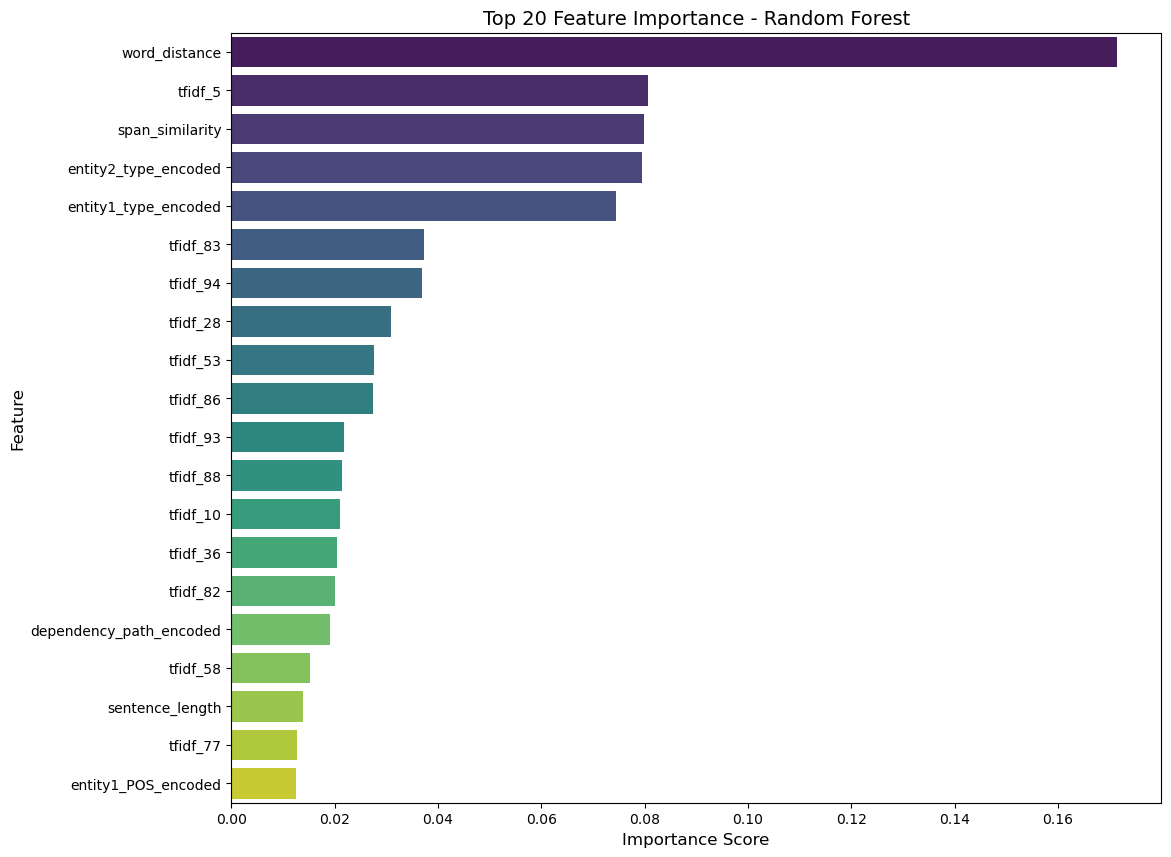

In [37]:
# Feature importance

# Train Random Forest with best hyperparameters (adjust if needed)
best_rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
best_rf.fit(X_train, y_train)

# Extract feature importance
feature_importance = best_rf.feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Improve feature importance plot by limiting features and adjusting labels
plt.figure(figsize=(12, 10))  # Increase figure size for better readability

# Select top 20 most important features for better visualization
top_n = 20
feature_importance_df_top = feature_importance_df.head(top_n)

sns.barplot(x="Importance", y="Feature", data=feature_importance_df_top, hue="Feature", palette="viridis", legend=False)

plt.title("Top 20 Feature Importance - Random Forest", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

## Model Testing

In [39]:
# Load the test dataset
X_test = pd.read_csv("ML_features_test.csv")

# Loading the trained XGBoost model
xgb_model = joblib.load("xgb_model.pkl")
predictions = xgb_model.predict(X_test.drop(["entity1", "entity2"], axis=1))

# Load the label encoder
label_encoders = joblib.load("label_encoders.pkl")

# Inverse transform the numerical labels back to category names
predictions = label_encoders["relation"].inverse_transform(predictions)

predicted_df = pd.DataFrame({
    "Entity 1": X_test["entity1"],
    "Entity 2": X_test["entity2"],
    "Predicted Relation": predictions
})
predicted_df.head()

,Entity 1,Entity 2,Predicted Relation
0,base classifiers,ensemble,USED-FOR
1,pairwise constraints,ensemble construction,USED-FOR
2,ensemble construction,ensemble construction,COREF
3,ensemble,ensemble construction,COREF
4,base classifiers,base classifiers,COREF
